In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

import os
import pandas as pd
import numpy as np
from scipy import stats as ss
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [33]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

## Произведем загрузку файла

In [9]:
for file in os.listdir(os.getcwd()):
    if 'csv' in file:
        PATH = os.path.abspath(file)

In [10]:
experiments_df = pd.read_csv(PATH, sep=';')

In [11]:
experiments_df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [12]:
experiments_df = experiments_df.drop(columns='Unnamed: 0')

In [13]:
experiments_df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [14]:
experiments_df.value = experiments_df.value.str.replace(',', '.').astype('float')

In [15]:
experiments_df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


## Посчитаем p-value тремя способами: t-тест, U-тест, бутстрап 

### t-тест

##### Посмотрим на картину распределения

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


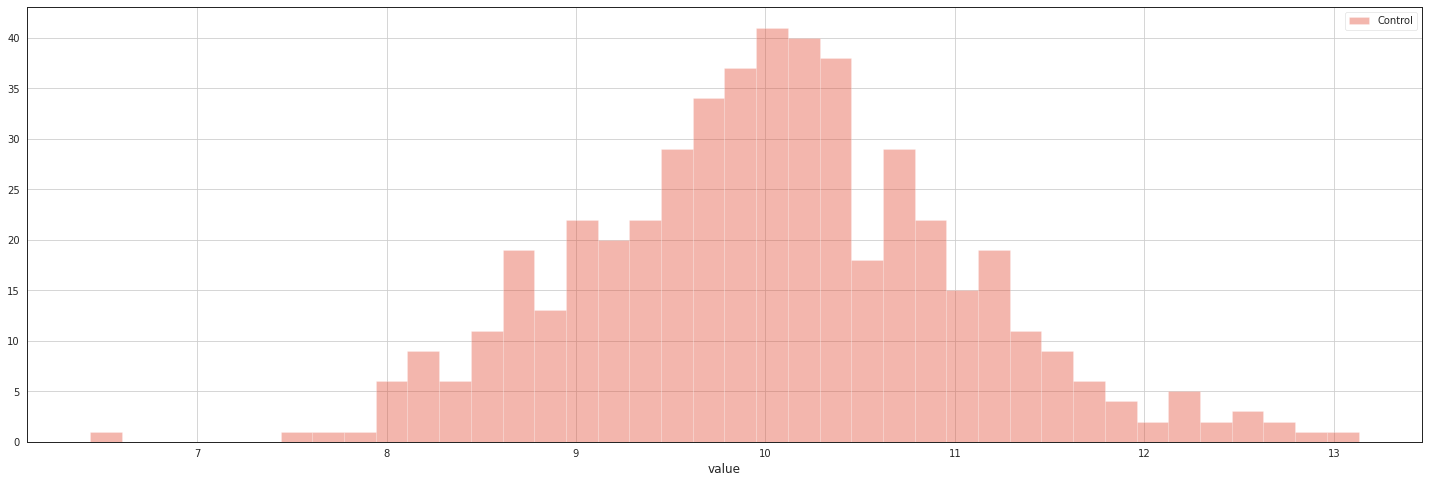

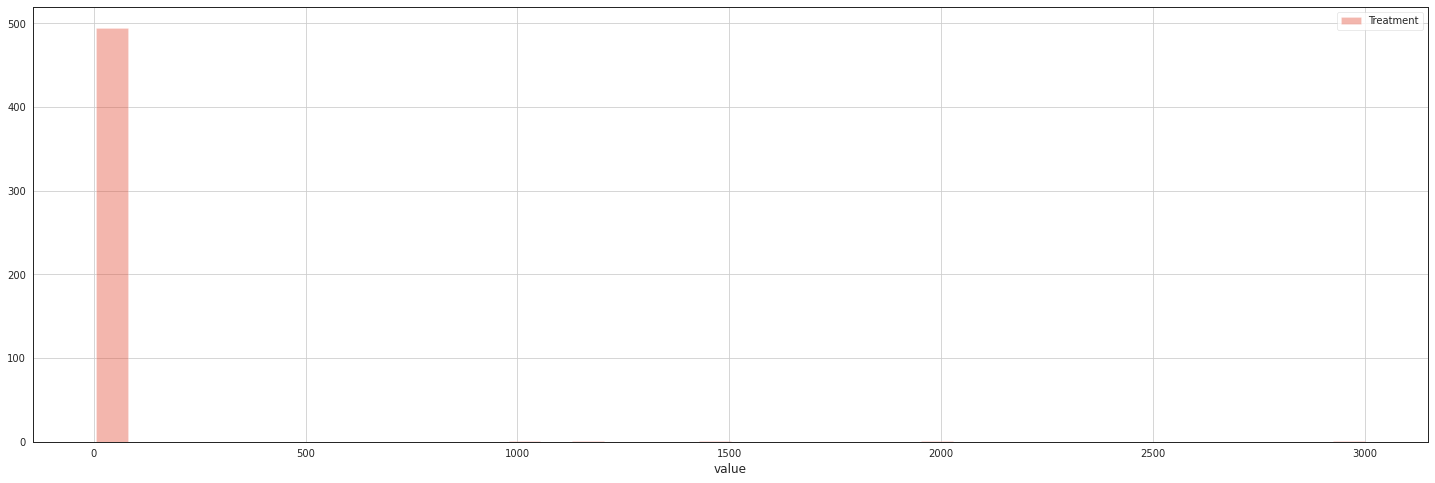

In [17]:
for variant in experiments_df.experimentVariant.unique():
    plt.figure(figsize = (25,8))
    sns.set_style("white")
    sns.distplot(experiments_df.query('experimentVariant == @variant').value, bins=40, kde=False, label=variant)
    plt.legend()
    plt.grid()
plt.show()

#### Вывод:
Наблюдаем выбросы для тестовой группы

##### Проверим количество значений в разных контрольных группах

In [18]:
experiments_df.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

In [19]:
test_values = experiments_df.query('experimentVariant == "Treatment"').value
control_values = experiments_df.query('experimentVariant == "Control"').value

##### Проверка на нормальность выборок из ГС

In [37]:
ss.shapiro(test_values)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [39]:
ss.shapiro(control_values_sample)

ShapiroResult(statistic=0.9944307208061218, pvalue=0.4907117187976837)

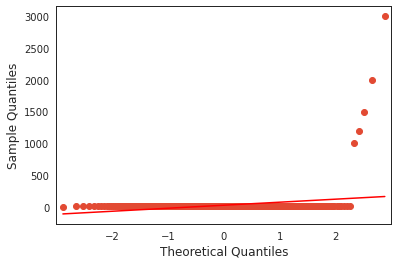

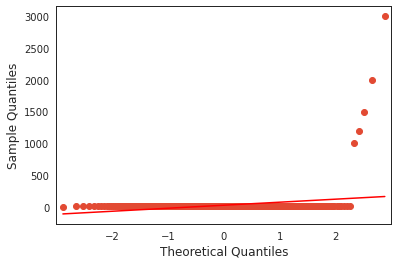

In [24]:
sm.qqplot(test_values, line='r')

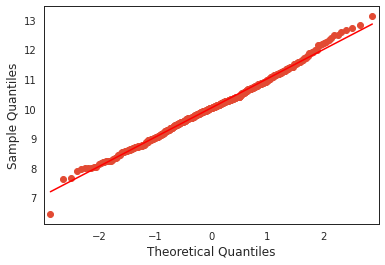

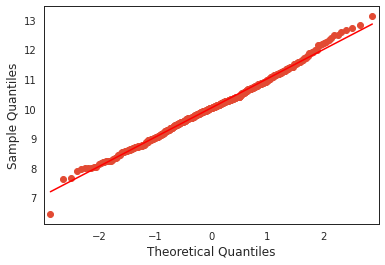

In [25]:
sm.qqplot(control_values, line='r')

#### Вывод:
Анализ данных выборки тестовой группы не позволяет сказать, что это распределение в ГС - нормальное, согласно результатам теста Шапиро-Уилка. А как известно, для получения адекватных результатов при помощи t-критерия Стьюдента предпочтительно выполнение требования к нормальности распределения признака в ГС у обеих групп. Также, по результатам построения распределения видно, что для тестовой группы присутствуют выбросы.

###  t-test

In [26]:
test_values.mean()

27.321499056661573

In [27]:
control_values.mean()

10.026866533804297

In [28]:
ss.ttest_ind(test_values, control_values)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

#### Вывод:

В связи с полученным значенем p-value < 0.05, мы можем отклонить H0, согласно которой разница между средними нашей выборки не имеет различия со средним ГС. Соответственно, средние в группах __значимо различаются__.

### U-тест

##### Основываясь на том, что непараметрический тест Манна-Уитни дает отличные от теста Стьюдента результаты на выборках с выбросами, посмотрим на результат проведения U-теста

In [36]:
ss.mannwhitneyu(test_values, control_values)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

#### Вывод:

Т.к. __p-value > 0.05__, у нас __нет достаточно оснований отвергать нулевую гипотезу__, согласно которой разница между средними наших выборок не отличается от среднего в ГС. 

### Bootstrap

##### Bootstrap-распределения средних

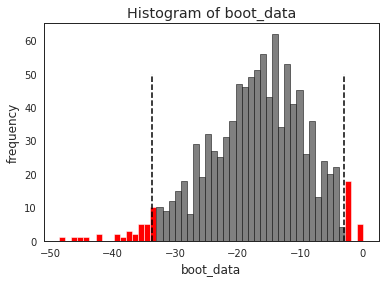

In [30]:
booted_data = get_bootstrap(control_values, test_values) 

In [31]:
booted_data['p_value']

0.032170457521692945

#### Вывод:

В связи с полученным значенем p-value < 0.05, а также тем, что 0 не попадает в границы доверительного интервала, полученого при бутстрепе, мы можем отклонить H0, согласно которой разница между средними нашей выборки не имеет различия со средним ГС. Соответственно, средние в группах __значимо различаются__.

##### Bootstrap-распределения медиан

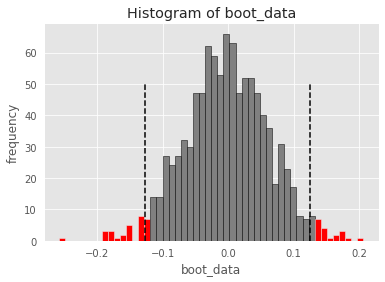

In [34]:
booted_data = get_bootstrap(control_values, test_values) 

In [35]:
booted_data['p_value']

0.9694779578320925

#### Вывод:

Т.к. __p-value > 0.05__, а также то, что __0 попадает в границы доверительного интервала__, полученого при бутстрепе, у нас __нет достаточно оснований отвергать нулевую гипотезу__, согласно которой разница между средними наших выборок не отличается от среднего в ГС. 

### Итоговый вывод

В результате оценки тремя критериями мы __наблюдаем конфликт в статзначимаости__.

На какие же результаты мы можем опереться для принятия решения о достоверности нулевой гипотезы?

Опираясь на то, что:
- при предварительном анализе мы получили __несоответствие данных из группы "treatment" нормальному распледелению__, что не позволяет полагать, что распределение этого признака в ГС нормальное;
- в виду предыдущего пункта, а так же зная эмпирический опыт, что __t-test дает правдоподобные результаты в случае ситуации, противоположной нашей__, более предпочтительными методами являются критерии Манна-Уитни и бутстреп;
- результаты __U-теста не позволяют отвергать нулевую гипотезу__;
- касаемо бутстрапирования наблюдается интереная особенность, что в случае, когда была взята за статистику в его механике __среднее__ - мы получаем __статзначимые результаты__, в случае __медианы - наоборот__. Учитывая, что в __данных тестируемой группы__ имеются довольно большие __выбросы__, есть смысл больше __доверять результатам, полученным в ходе использования медианы__. Соответственно, предпочтительный вариант __теста бустстрапированием не дает оснований отвергать нулевую гипотезу.

В виду вышеперечисленных тезисов, можно заключить, что __изменения, полученные в результате эксперимента не статзначимы__, соответственно __не наблюдается эффекта от введеных изменений__.

# Ответ преподавателя


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

Хорошего дня!